In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [4]:
def bin_mean(timestamps, df, df_keys, timelabel):
    mean = []
    std = []
    # error = []

    start_time = pd.to_datetime(timestamps[0])
    end_time = pd.to_datetime(timestamps[1])

    time = pd.to_datetime(df[timelabel])
    time_filter = (time >= start_time) & (time <= end_time)

    for key in df_keys:
        conc = np.array(df[key].dropna())
        
        # Convert the concentration data to numeric, coercing errors
        conc = pd.to_numeric(conc, errors='coerce')
        filtered_conc = conc[time_filter]
        bin_mean = filtered_conc.mean()
        bin_std = filtered_conc.std()
        # error_mean = bin_std / np.sqrt(len(filtered_conc))
        mean.append(bin_mean)
        std.append(bin_std)
        # error.append(error_mean)
    
    return mean, std #, error

def plot_bin_mean(ax, timestamps, df, df_keys, timelabel, bins, clr, axis_labels):
    mean, std = bin_mean(timestamps, df, df_keys, timelabel)

    min_std = []
    max_std = []
    for i, m in enumerate(mean):
        min_std.append(m - std[i])
        max_std.append(m + std[i])

    ax.plot(bins, mean, color = clr, ls = '-', lw = 1)
    ax.fill_between(bins, min_std, max_std, alpha = 0.2, color = clr, linewidth = 0)
    # ax.errorbar(bins, mean, std, ecolor='k', elinewidth=1, capsize=2, capthick=1)

    ax.set(xlabel = axis_labels[0], ylabel = axis_labels[1], xscale='log')

    # Set labels and title for the scatter plot
    ax.tick_params(axis = 'both', which = 'major', direction = 'out', bottom = True, left = True, labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'out', bottom = True, left = True)

In [5]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

In [6]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_cut_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()
OPS_ax_labels = ['Particle diameter / $\mu$m', 'Mean concentration / #/cm$^{3}$']

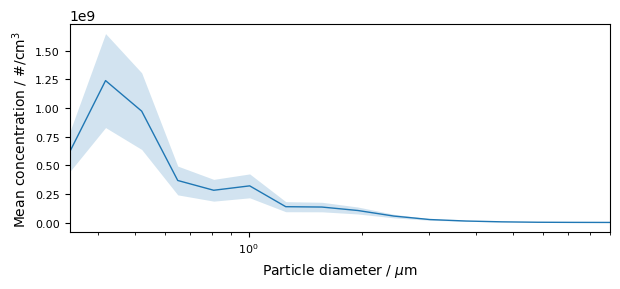

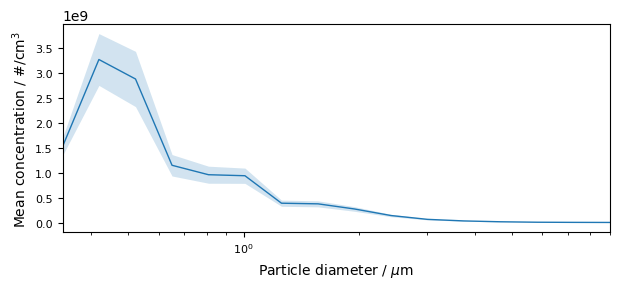

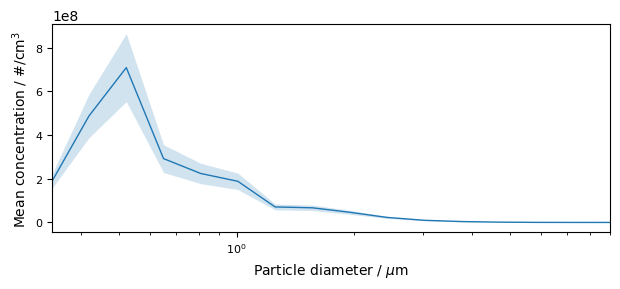

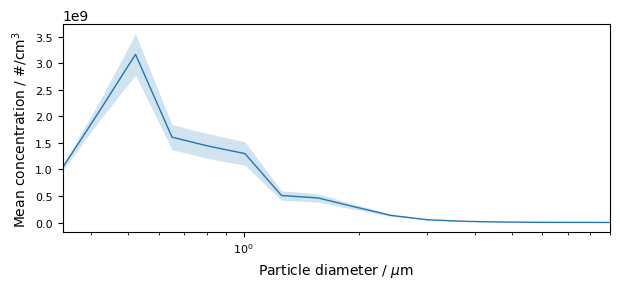

In [9]:
for i, key in enumerate(OPS_dict_keys):
    fig_name = 'Mean_concentrations/OPS_mean_' + key + '.png'

    fig, axes = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(axes, timestamps_exp[i], OPS_APS[key], OPS_bins, 'Time', OPS_cut_point, 'tab:blue', OPS_ax_labels)

    axes.set_xlim(min(OPS_cut_point), max(OPS_cut_point))

    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)

In [6]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key))
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()
NanoScan_ax_labels = ['Particle diameter / nm', 'Mean concentration / #/cm$^{3}$']

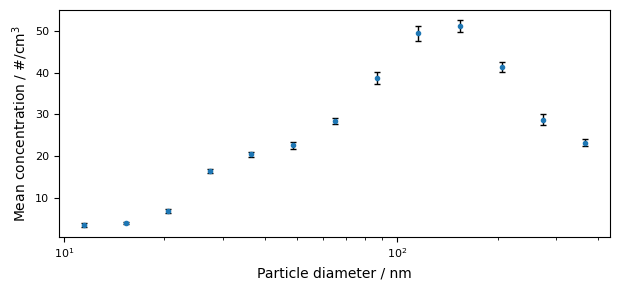

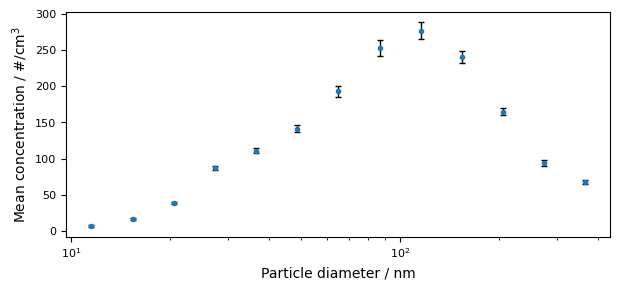

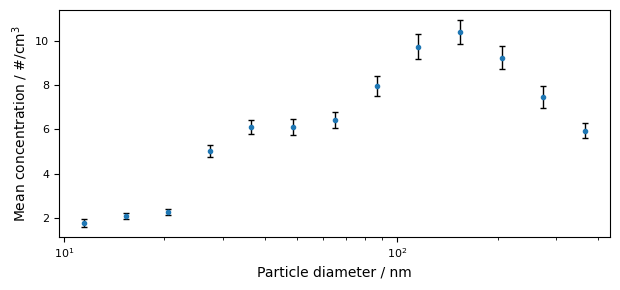

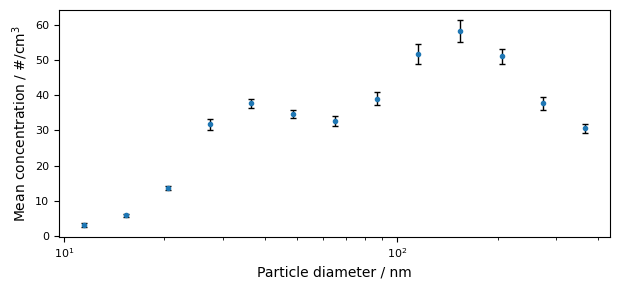

In [7]:
for i, key in enumerate(NanoScan_dict_keys):
    exp_number = i + 1
    fig_name = 'Mean_concentrations/NanoScan_mean_Exp' + str(exp_number) + '.png'

    fig, axes = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(axes, timestamps_exp[i], SMPS[key], NanoScan_Bins, 'Time', NanoScan_bin_mean, NanoScan_ax_labels)

    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)

In [8]:
APS_dict_keys = ['20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[4:56].to_list()
APS_bin_mean = [0.523]
for key in OPS_APS['20241016_APS'].keys()[5:56]:
    APS_bin_mean.append(float(key))

APS_ax_labels_number = ['Particle diameter / $\mu$m', 'Mean concentration / #/cm$^{3}$']
APS_ax_labels_mass = ['Particle diameter / $\mu$m', 'Mean concentration / mg/m$^{3}$']

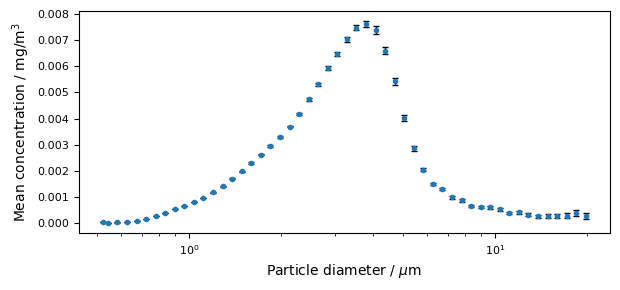

In [9]:
fig_name = 'Mean_concentrations/APS_mean_' + 'Exp1' + '.png'

fig, axes = plt.subplots(figsize = (6.3, 3))

plot_bin_mean(axes, timestamps_exp[0], OPS_APS['20241016_APS'], APS_bins, 'Time', APS_bin_mean, APS_ax_labels_mass)

fig.tight_layout()
fig.savefig(fig_name, dpi = 600)

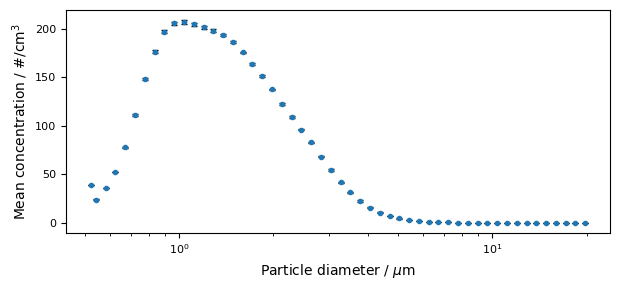

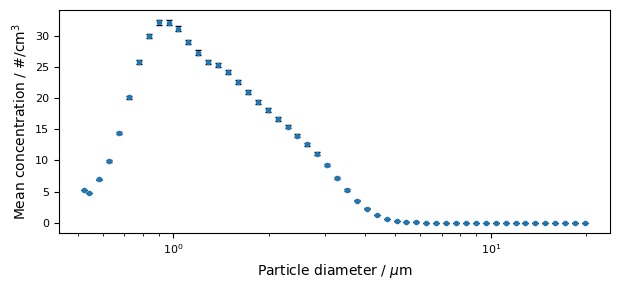

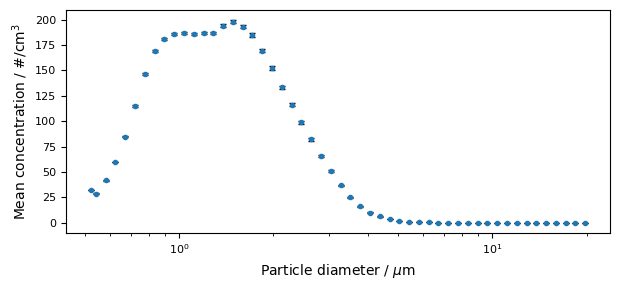

In [10]:
for i, key in enumerate(APS_dict_keys):
    exp_number = i + 2
    fig_name = 'Mean_concentrations/APS_mean_Exp' + str(exp_number) + '.png'

    fig, axes = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(axes, timestamps_exp[i+1], OPS_APS[key], APS_bins, 'Time', APS_bin_mean, APS_ax_labels_number)
    
    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)

In [11]:
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[83:196].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[83:196]:
    SMPS_bin_mean.append(float(key))

SMPS_ax_labels = ['Particle diameter / nm', 'Mean concentration/ #/cm$^{3}$']

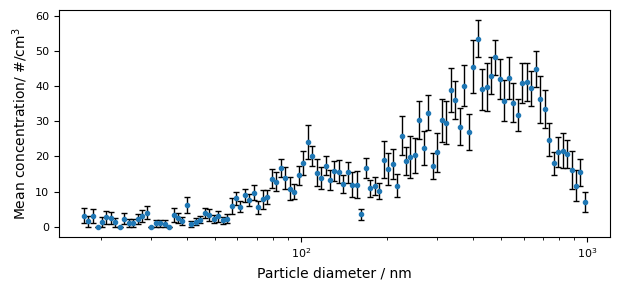

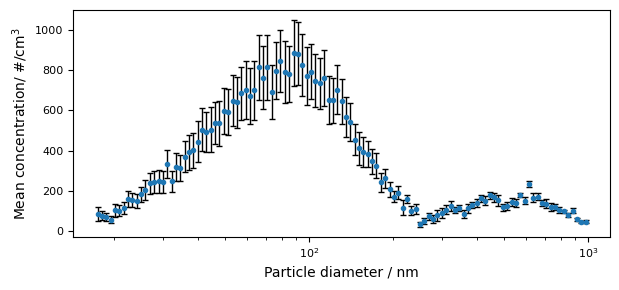

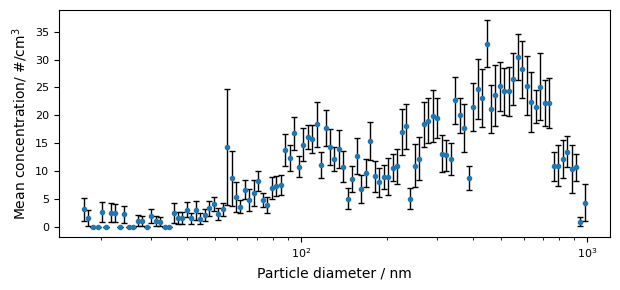

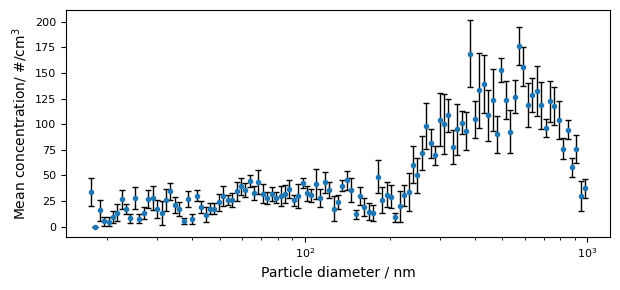

In [12]:
for i, key in enumerate(SMPS_dict_keys):
    exp_number = i + 1
    fig_name = 'Mean_concentrations/SMPS_mean_Exp' + str(exp_number) + '.png'

    fig, ax = plt.subplots(figsize = (6.3, 3))

    plot_bin_mean(ax, timestamps_exp[i], SMPS[key], SMPS_bins, 'Time', SMPS_bin_mean, SMPS_ax_labels)

    fig.tight_layout()
    fig.savefig(fig_name, dpi = 600)